In [145]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import operator
from sklearn import preprocessing
from sklearn.feature_extraction import FeatureHasher
import copy
from sklearn.linear_model import LogisticRegression
from scipy import interp
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from collections import Counter
%matplotlib inline

In [111]:
def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        ) 
        
        return 
    
    lb = LabelBinarizer()
    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(y_pred,return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(y_true=y_true,y_pred=y_pred,labels=labels)

    avg = list(precision_recall_fscore_support(y_true=y_true, y_pred=y_pred,average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(list(metrics_summary),index=metrics_sum_index,columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

In [112]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [60]:
train = pd.read_csv('/Users/yxll/Desktop/nerdwallet assignment/train_nw.csv')

In [15]:
#check missing data in each column
data_check=pd.DataFrame(train[feat_labels].isna().sum())
data_check['percentage']=data_check[0]/len(train)

In [17]:
#PRIMEUNIT and AUCGUART has > 90% null value, remove from analysis
data_check

,0,percentage
PurchDate,0,0.000000
Auction,0,0.000000
VehYear,0,0.000000
Make,0,0.000000
Model,0,0.000000
Trim,1694,0.032715
SubModel,6,0.000116
Color,6,0.000116
Transmission,7,0.000135
WheelTypeID,2211,0.042700


In [97]:
#remove PRIMEUNIT and AUCGUART due to data quality
#remove WheelType due to info duplication
#remove VNZIP due to info duplication
#remove RefID for useless info
#remove PurchDate
unwanted = ['PurchDate', 'WheelType', 'PRIMEUNIT', 'AUCGUART', 'VNZIP1']
feat_labels=[e for e in list(train)[:-1][1:] if e not in unwanted]

['Auction',
 'VehYear',
 'Make',
 'Model',
 'Trim',
 'SubModel',
 'Color',
 'Transmission',
 'WheelTypeID',
 'VehOdo',
 'Size',
 'MMRAcquisitionAuctionAveragePrice',
 'MMRAcquisitionAuctionCleanPrice',
 'MMRAcquisitionRetailAveragePrice',
 'MMRAcquisitonRetailCleanPrice',
 'MMRCurrentAuctionAveragePrice',
 'MMRCurrentAuctionCleanPrice',
 'MMRCurrentRetailAveragePrice',
 'MMRCurrentRetailCleanPrice',
 'BYRNO',
 'VNST',
 'VehBCost',
 'IsOnlineSale',
 'WarrantyCost']

In [64]:
#covert vehicle year to years from 2018
train['VehYear']=2018-train['VehYear']

In [90]:
#feature selection
#Pick threshold of 0.05
import scipy.stats as stats
from scipy.stats import chi2_contingency

class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.dfTabular = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
            result = ""
            if self.p<alpha:
                result="{0} is IMPORTANT".format(colX)
            else:
                result="{0} is NOT IMPORTANT".format(colX)

            print(result)

    def TestIndependence(self,colX,colY, alpha=0.05):
            X = self.df[colX].astype(str)
            Y = self.df[colY].astype(str)

            self.dfObserved = pd.crosstab(Y,X) 
            chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
            self.p = p
            self.chi2 = chi2
            self.dof = dof 

            self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)

            self._print_chisquare_result(colX, alpha)

In [92]:
cT = ChiSquare(train)
for var in feat_labels:
    cT.TestIndependence(colX=var,colY="IsBadBuy") 

Auction is IMPORTANT
VehYear is IMPORTANT
Make is IMPORTANT
Model is IMPORTANT
Trim is IMPORTANT
SubModel is IMPORTANT
Color is IMPORTANT
Transmission is NOT IMPORTANT
WheelTypeID is IMPORTANT
VehOdo is IMPORTANT
Size is IMPORTANT
MMRAcquisitionAuctionAveragePrice is IMPORTANT
MMRAcquisitionAuctionCleanPrice is IMPORTANT
MMRAcquisitionRetailAveragePrice is IMPORTANT
MMRAcquisitonRetailCleanPrice is IMPORTANT
MMRCurrentAuctionAveragePrice is IMPORTANT
MMRCurrentAuctionCleanPrice is IMPORTANT
MMRCurrentRetailAveragePrice is IMPORTANT
MMRCurrentRetailCleanPrice is IMPORTANT
BYRNO is IMPORTANT
VNST is IMPORTANT
VehBCost is IMPORTANT
IsOnlineSale is NOT IMPORTANT
WarrantyCost is IMPORTANT


In [99]:
#keep only theimportant features
unwanted = ['Transmission', 'IsOnlineSale']
feat_labels=[e for e in feat_labels if e not in unwanted]

In [100]:
# Create a list of feature names
# sample train and test set
y = train["IsBadBuy"]
X = train.fillna(0)[feat_labels]

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [67]:
#calculate class ratio
weight=[(Counter(y)[i] / len(y) * 100.0) for i in Counter(y)]

In [68]:
#check class imbalance or not
#the data has 87% class 0 and 13% class 1
#considered as imbalanced data
weight

[87.60525299343375, 12.394747006566242]

In [107]:
X_train_hash = copy.copy(X_train)
X_test_hash = copy.copy(X_test)
for i in range(X_train_hash.shape[1]):
    X_train_hash.iloc[:,i]=X_train_hash.iloc[:,i].astype('str')
for i in range(X_test_hash.shape[1]):
    X_test_hash.iloc[:,i]=X_test_hash.iloc[:,i].astype('str')
h = FeatureHasher(n_features=100,input_type="string")
X_train_hash = h.transform(X_train_hash.values)
X_test_hash = h.transform(X_test_hash.values)

0.3412042890809873


0.3561490117777587
Final Report for LR
             precision    recall  f1-score  support     pred
0             0.876320  0.998455  0.933409   9062.0  10325.0
1             0.548387  0.013138  0.025660   1294.0     31.0
avg / total   0.835344  0.875338  0.819984  10356.0  10356.0
Confusion matrix, without normalization
[[9048   14]
 [1277   17]]


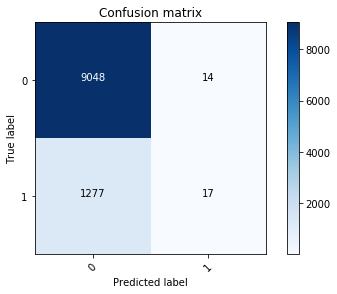

In [121]:
l = LogisticRegression()
r = RandomForestClassifier(n_estimators=25,max_depth=10)

l.fit(X_train_hash,y_train)
y_pred = l.predict_proba(X_test_hash)
l_pred=pd.DataFrame.from_records(y_pred)
l_pred['pred']=np.where(l_pred[0]>l_pred[1], 0, 1)

sk_report = class_report(y_true=y_test, y_pred=l_pred['pred'])
print("Final Report for LR")
print(sk_report)
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, l_pred['pred']), classes=[0,1])

Final Report for RF
             precision    recall  f1-score  support     pred
0             0.876706  0.999669  0.934158   9062.0  10333.0
1             0.869565  0.015456  0.030372   1294.0     23.0
avg / total   0.875813  0.876690  0.821229  10356.0  10356.0
Confusion matrix, without normalization
[[9059    3]
 [1274   20]]


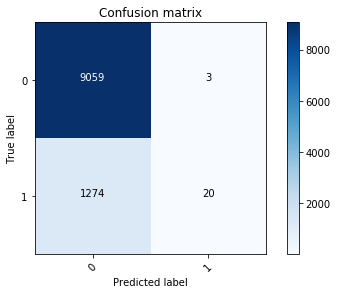

In [143]:
r.fit(X_train_hash,y_train)
y_pred = r.predict_proba(X_test_hash)
r_pred=pd.DataFrame.from_records(y_pred)
r_pred['pred']=np.where(r_pred[0]>r_pred[1], 0, 1)

sk_report = class_report(y_true=y_test, y_pred=r_pred['pred'])
print("Final Report for RF")
print(sk_report)
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, r_pred['pred']), classes=[0,1])

Final Report for RF_Weighted
             precision    recall  f1-score  support     pred
0             0.875979  1.000000  0.933890   9062.0  10345.0
1             1.000000  0.008501  0.016858   1294.0     11.0
avg / total   0.891475  0.876110  0.819305  10356.0  10356.0
Confusion matrix, without normalization
[[9062    0]
 [1283   11]]


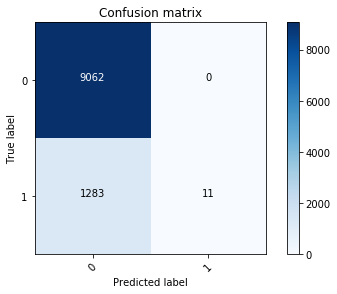

In [142]:
#add class weight to RF model to address imbalance data issue
r_weighted = RandomForestClassifier(n_estimators=25,max_depth=10,class_weight = {0:weight[1],1:weight[0]})
r_weighted.fit(X_train_hash,y_train)
y_pred = r.predict_proba(X_test_hash)
r_weighted_pred=pd.DataFrame.from_records(y_pred)
r_weighted_pred['pred']=np.where(r_weighted_pred[0]>r_weighted_pred[1], 0, 1)

sk_report = class_report(y_true=y_test, y_pred=r_weighted_pred['pred'])
print("Final Report for RF_Weighted")
print(sk_report)
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, r_weighted_pred['pred']), classes=[0,1])

In [147]:
#apply SMOTE to balance 0 and 1
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train_hash, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, the shape of train_X: (72600, 100)
After OverSampling, the shape of train_y: (72600,) 

After OverSampling, counts of label '1': 36300
After OverSampling, counts of label '0': 36300


Final Report for RF w/SMOTE
             precision    recall  f1-score  support     pred
0             0.899694  0.972964  0.934896   9062.0   9800.0
1             0.559353  0.240340  0.336216   1294.0    556.0
avg / total   0.857168  0.881421  0.860090  10356.0  10356.0
Confusion matrix, without normalization
[[8817  245]
 [ 983  311]]


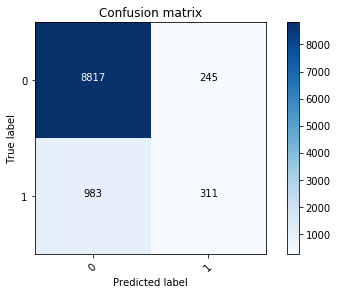

In [150]:
#data after SMOTE does f1_score for class 1 prediction better
r.fit(X_train_res,y_train_res)
y_pred = r.predict_proba(X_test_hash)
r_pred=pd.DataFrame.from_records(y_pred)
r_pred['pred']=np.where(r_pred[0]>r_pred[1], 0, 1)

sk_report = class_report(y_true=y_test, y_pred=r_pred['pred'])
print("Final Report for RF w/SMOTE")
print(sk_report)
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, r_pred['pred']), classes=[0,1])

In [137]:
#use RF model w/SMOTE to train all train set and make prediction on test set
test = pd.read_csv('/Users/yxll/Desktop/nerdwallet assignment/test_nw.csv')
refid=test['RefId']
test=test.fillna(0)[feat_labels]

In [131]:
X_hash = copy.copy(X)
test_hash = copy.copy(test)
for i in range(X_hash.shape[1]):
    X_hash.iloc[:,i]=X_hash.iloc[:,i].astype('str')
for i in range(test_hash.shape[1]):
    test_hash.iloc[:,i]=test_hash.iloc[:,i].astype('str')
h = FeatureHasher(n_features=100,input_type="string")
X_hash = h.transform(X_hash.values)
test_hash = h.transform(test_hash.values)

In [151]:
X_res, y_res = sm.fit_sample(X_hash, y.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res==0)))

After OverSampling, the shape of train_X: (90724, 100)
After OverSampling, the shape of train_y: (90724,) 

After OverSampling, counts of label '1': 45362
After OverSampling, counts of label '0': 45362


In [152]:
r.fit(X_res,y_res)
y_pred = r.predict_proba(test_hash)
r_weighted_pred_final=pd.DataFrame.from_records(y_pred)
r_weighted_pred_final['pred']=np.where(r_weighted_pred_final[0]>r_weighted_pred_final[1], 0, 1)

In [153]:
#add back refid
r_weighted_pred_final['RefId']=refid

In [154]:
#export to csv
r_weighted_pred_final.to_csv('/Users/yxll/Desktop/nerdwallet assignment/test_predictions.csv', index=False)